# **ĐỒ ÁN CUỐI KÌ THU THẬP VÀ TIỀN XỬ LÝ DỮ LIỆU.**

ĐỀ TÀI: PHÂN TÍCH CÁC YÊU TỐ ẢNH HƯỞNG ĐẾN ĐẾN RATING CỦA MỘT ĐẦU SÁCH.

Bộ dữ liệu được thu thập từ trang https://www.goodreads.com/ bằng python.

Trong đề tài này nhóm em lựa chọn list các sách hay nhất trong thế kỉ 21.

# PHẦN 1: TIỀN XỬ LÝ DỮ LIỆU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Đọc dữ liệu đã thu thập được.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/Đồ Án-DS105/Data/data.csv')
# Xóa những hàng bị trùng.
df= df.drop_duplicates( keep='last')
df.head(5)

,Unnamed: 0,id,title,link,serie,author,author_link,rating_count,eview_count,number_of_pages,date_published,publisher,original_title,genre_and_votes,isbn,isbn13,setting,characters,description,awards,rating
0,0,136251,Harry Potter and the Deathly Hallows,https://www.goodreads.com/book/show/136251.Har...,(Harry Potter #7),J.K. Rowling,https://www.goodreads.com/author/show/1077326....,3105877.0,71353.0,759.0,July 21st 2007,Arthur A. Levine Books,Harry Potter and the Deathly Hallows,"Fantasy 51882, Young Adult 16499, Fiction 1470...",NaN,NaN,"London, England\n\nHogwarts School of Witchcra...","Sirius Black, Draco Malfoy, Ron Weasley, Petun...","It&aposs no longer safe for Harry at Hogwarts,...",Locus Award Nominee for Best Young Adult Novel...,4.61
1,1,2767052,The Hunger Games,https://www.goodreads.com/book/show/2767052-th...,(The Hunger Games #1),Suzanne Collins,https://www.goodreads.com/author/show/153394.S...,7026399.0,179928.0,374.0,October 14th 2008,Scholastic Press,The Hunger Games,"Young Adult 32219, Fiction 18372, Science Fict...",0439023483,9780439023481.0,"District 12, Panem\n\nCapitol, Panem\n\nPanem\...","Katniss Everdeen, Peeta Mellark, Cato (Hunger ...","Could you survive on your own in the wild, wit...",Locus Award Nominee for Best Young Adult Book ...,4.32
2,2,77203,The Kite Runner,https://www.goodreads.com/book/show/77203.The_...,NaN,Khaled Hosseini,https://www.goodreads.com/author/show/569.Khal...,2654792.0,80553.0,371.0,May 2004,Riverhead Books,The Kite Runner,"Fiction 16839, Historical-Historical Fiction 6...",NaN,NaN,Kabul\n\n(Afghanistan)\n\n\nAfghanistan,"Assef, Rahim Khan, Amir (The Kite Runner), Has...","The unforgettable, heartbreaking story of the ...",Borders Original Voices Award for Fiction (200...,4.31
3,3,19063,The Book Thief,https://www.goodreads.com/book/show/19063.The_...,NaN,Markus Zusak,https://www.goodreads.com/author/show/11466.Ma...,2062051.0,121442.0,552.0,March 14th 2006,Alfred A. Knopf,The Book Thief,"Historical-Historical Fiction 21126, Fiction 1...",NaN,NaN,"Molching,\n1939\n\n(Germany)\n\n\nGermany","Liesel Meminger, Hans Hubermann, Rudy Steiner,...",Librarian&aposs note: An alternate cover editi...,National Jewish Book Award for Children’s and ...,4.38
4,4,1,Harry Potter and the Half-Blood Prince,https://www.goodreads.com/book/show/1.Harry_Po...,(Harry Potter #6),J.K. Rowling,https://www.goodreads.com/author/show/1077326....,2709343.0,44644.0,652.0,September 16th 2006,Scholastic Inc.,Harry Potter and the Half-Blood Prince,"Fantasy 51823, Young Adult 16169, Fiction 1472...",NaN,NaN,Hogwarts School of Witchcraft and Wizardry\n\n...,"Draco Malfoy, Ron Weasley, Petunia Dursley, Ve...",The war against Voldemort is not going well; e...,Locus Award Nominee for Best Young Adult Novel...,4.57


In [4]:
# Đổi tên cột bị sai.
df=df.rename(columns = {'eview_count':'review_count'})
df=df.rename(columns = {'serie':'series'})

In [5]:
del df['Unnamed: 0']

In [6]:
df.shape

(9198, 20)

**- Dữ liệu ban đầu có 9198 sample và 20 thuộc tính.**

In [7]:
df.dtypes

id                   int64
title               object
link                object
series              object
author              object
author_link         object
rating_count       float64
review_count       float64
number_of_pages    float64
date_published      object
publisher           object
original_title      object
genre_and_votes     object
isbn                object
isbn13              object
setting             object
characters          object
description         object
awards              object
rating             float64
dtype: object

In [8]:
df.sample(5)

,id,title,link,series,author,author_link,rating_count,review_count,number_of_pages,date_published,publisher,original_title,genre_and_votes,isbn,isbn13,setting,characters,description,awards,rating
631,25668970,Speedy Reads,https://www.goodreads.com/book/show/25668970-s...,NaN,Chris-Jean Clarke,https://www.goodreads.com/author/show/7377174....,38.0,5.0,66.0,July 30th 2015,BookRix.com,NaN,NaN,NaN,NaN,NaN,NaN,PLEASE NOTE: Readers are currently unable to p...,NaN,4.66
2506,1220721,What I Was,https://www.goodreads.com/book/show/1220721.Wh...,NaN,Meg Rosoff,https://www.goodreads.com/author/show/93575.Me...,4168.0,531.0,209.0,February 1st 2008,Viking Books,What I Was,"Young Adult 152, Fiction 112, Historical-Histo...",0670018449,9780670018444.0,NaN,NaN,An unusual coming-of-age story that examines t...,"Goldener Lufti (2010), Carnegie Medal Nominee ...",3.49
9196,3507618,Fruitless Fall: The Collapse of the Honey Bee ...,https://www.goodreads.com/book/show/3507618-fr...,NaN,Rowan Jacobsen,https://www.goodreads.com/author/show/16940.Ro...,685.0,136.0,288.0,September 16th 2008,Bloomsbury USA,Fruitless Fall: The Collapse of the Honeybee a...,"Nonfiction 52, Science 33, Environment-Nature ...",1596915374,9781596915374.0,NaN,NaN,How the disappearance of the world&aposs honey...,NaN,4.31
916,2845287,The Wordy Shipmates,https://www.goodreads.com/book/show/2845287-th...,NaN,Sarah Vowell,https://www.goodreads.com/author/show/2122.Sar...,25164.0,2719.0,272.0,October 7th 2008,Riverhead Books,The Wordy Shipmates,"Nonfiction 962, History 365, Humor 311, North ...",1594489998,9781594489990.0,Massachusetts\n\n(United States),NaN,The Wordy Shipmates is an exploration of the P...,Indies Choice Book Award for Best Conversation...,3.66
3607,12843362,Off the Mat,https://www.goodreads.com/book/show/12843362-o...,NaN,Jeff Bibbey,https://www.goodreads.com/author/show/5266118....,7.0,3.0,238.0,August 1st 2011,Booklocker.com,NaN,NaN,1614344396,9781614344391,NaN,NaN,Devin Thomsen and Steven Matchik seek intensit...,NaN,4.43


=> Bộ dữ liệu ban đầu gồm có 9198 điểm dữ liệu và bao gồm 20 thuộc tính thu thập được. Bước tiếp theo là xử lý các giá trị missing.


## Kiểm tra các dữ liệu missing.

In [9]:
# Xoá 2 cột links của sách và tác giá. Do không liên quán đến kết quả ratting.
df.drop(['link', 'author_link'], axis=1, inplace=True)

In [10]:
df.head(2)

,id,title,series,author,rating_count,review_count,number_of_pages,date_published,publisher,original_title,genre_and_votes,isbn,isbn13,setting,characters,description,awards,rating
0,136251,Harry Potter and the Deathly Hallows,(Harry Potter #7),J.K. Rowling,3105877.0,71353.0,759.0,July 21st 2007,Arthur A. Levine Books,Harry Potter and the Deathly Hallows,"Fantasy 51882, Young Adult 16499, Fiction 1470...",NaN,NaN,"London, England\n\nHogwarts School of Witchcra...","Sirius Black, Draco Malfoy, Ron Weasley, Petun...","It&aposs no longer safe for Harry at Hogwarts,...",Locus Award Nominee for Best Young Adult Novel...,4.61
1,2767052,The Hunger Games,(The Hunger Games #1),Suzanne Collins,7026399.0,179928.0,374.0,October 14th 2008,Scholastic Press,The Hunger Games,"Young Adult 32219, Fiction 18372, Science Fict...",0439023483,9780439023481.0,"District 12, Panem\n\nCapitol, Panem\n\nPanem\...","Katniss Everdeen, Peeta Mellark, Cato (Hunger ...","Could you survive on your own in the wild, wit...",Locus Award Nominee for Best Young Adult Book ...,4.32


Mục đích là dự đoán rating cho nên thuộc tính rating là thiết yếu, vì vậy ta sẽ xóa những điểm thiếu cột rating.

In [11]:
df=df.dropna(axis=0,subset=['rating'])
df = df[df.rating != 0.0] # xóa các rating = 0

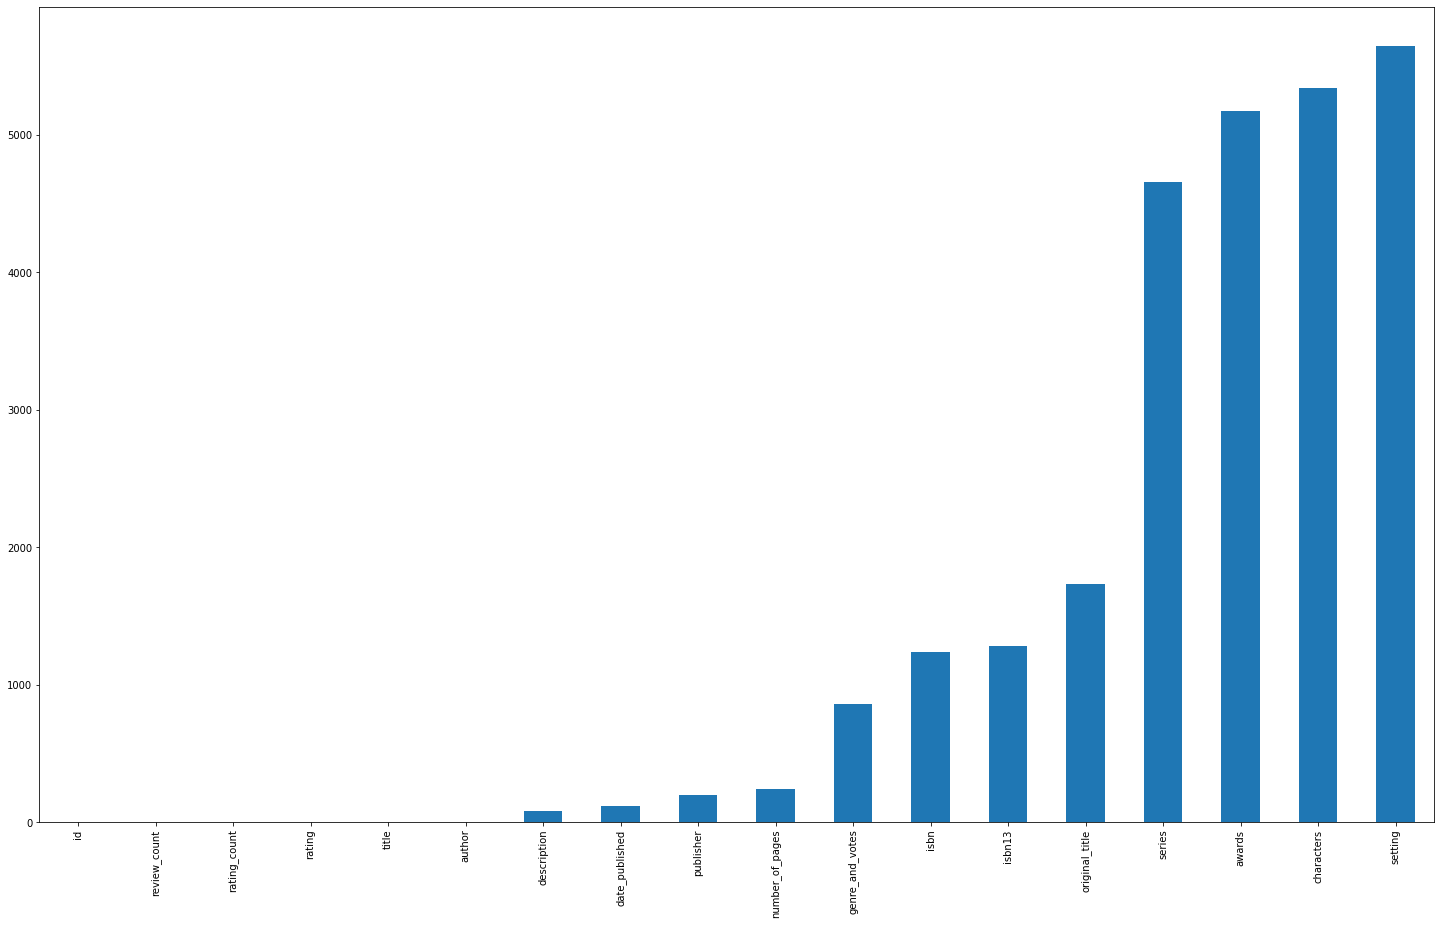

In [12]:
# Kiểm tra mức độ mising.
fig,ax = plt.subplots(figsize=(25,15))
missing=df.isnull().sum()
missing.sort_values(inplace=True)
missing.plot.bar()

- Quan sát đồ thị biểu diễn missing. 2 thuộc tính cuối cùng có tỷ lệ missing rất ca. Đồng thời do ở dạng list các string cho nên rất khó để xử lý.

In [ ]:
# Do tỷ lệ missing lên tới hơn 6000 điểm dữ liệu. Rất khó để xử lý nên chúng ta sẽ xóa 2 cột này.
df.drop(['setting'], axis=1, inplace=True)
df.drop(['characters'], axis=1, inplace=True)

In [ ]:
df.head(2)

,id,title,series,author,rating_count,review_count,number_of_pages,date_published,publisher,original_title,genre_and_votes,isbn,isbn13,description,awards,rating
0,136251,Harry Potter and the Deathly Hallows,(Harry Potter #7),J.K. Rowling,3105877.0,71353.0,759.0,July 21st 2007,Arthur A. Levine Books,Harry Potter and the Deathly Hallows,"Fantasy 51882, Young Adult 16499, Fiction 1470...",NaN,NaN,"It&aposs no longer safe for Harry at Hogwarts,...",Locus Award Nominee for Best Young Adult Novel...,4.61
1,2767052,The Hunger Games,(The Hunger Games #1),Suzanne Collins,7026399.0,179928.0,374.0,October 14th 2008,Scholastic Press,The Hunger Games,"Young Adult 32219, Fiction 18372, Science Fict...",0439023483,9780439023481.0,"Could you survive on your own in the wild, wit...",Locus Award Nominee for Best Young Adult Book ...,4.32


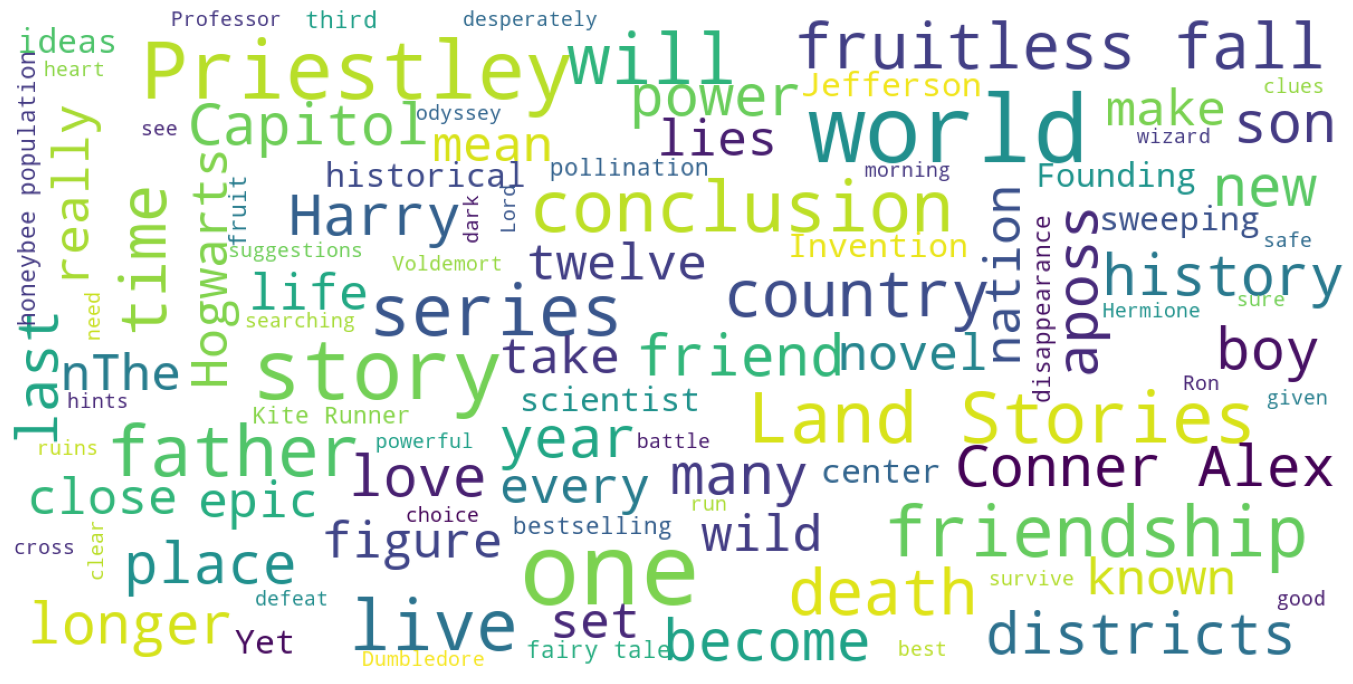

In [ ]:
#WordCloud của Description
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(24, 24))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(df['description'].values)

- Thuộc tính isbn13 là mã vạch bao gồm các thông tin sách. Cần có một cách đặc biệt để đọc thông tin. Và là dạng mã vạch mới hơn so với isbn. Vì vậy ta có thể xóa bỏ cột một trong 2 cột này. 

In [ ]:
df.drop(['isbn13'], axis=1, inplace=True)

In [ ]:
df.isnull().sum()

id                    0
title                 0
series             4657
author                0
rating_count          0
review_count          0
number_of_pages     240
date_published      115
publisher           200
original_title     1735
genre_and_votes     860
isbn               1240
description          78
awards             5174
rating                0
dtype: int64

In [ ]:
df['original_title'].nunique()

6375

- Do original_title có quá nhiều giá trị khác biệt cũng như không có tính chất phân loại vì thế ta sẽ loại bỏ thuộc tính này.

In [ ]:
df.drop(['original_title'], axis=1, inplace=True)

## Tiền Xử lý dữ liệu từng cột.

In [ ]:
df.head(1)

,id,title,series,author,rating_count,review_count,number_of_pages,date_published,publisher,genre_and_votes,isbn,description,awards,rating
0,136251,Harry Potter and the Deathly Hallows,(Harry Potter #7),J.K. Rowling,3105877.0,71353.0,759.0,July 21st 2007,Arthur A. Levine Books,"Fantasy 51882, Young Adult 16499, Fiction 1470...",NaN,"It&aposs no longer safe for Harry at Hogwarts,...",Locus Award Nominee for Best Young Adult Novel...,4.61


### Xử lý cột series.

Giá trị 'series' có dạng (abc #x) ta xét format lại dạng abc. Còn những sample nị null là những sách lẻ ta sẽ gắn là single.

In [ ]:
def formatTextSeries(text):
  """
  Parameters: str
  Return: formated str
  """
  if text != text: # Kiểm tra giá trị null
    return 'Single'
  return text.strip('()').split('#')[0].strip()
def formatSeries(df):
  """
  Parameters: DataFrame
  Return: DataFrame with formated 'series' column
  """
  df_copy = df.copy()
  df_copy['series'] = df_copy['series'].apply(formatTextSeries)
  return df_copy

In [ ]:
df=formatSeries(df)

In [ ]:
df['series'][432]

'Single'

### Xử lý cột date_published.

Do fomat ngày tháng năm không đầy đủ hoắc bị thiếu nên ta sẽ format về dạng chỉ có năm

In [ ]:
df['date_published'].unique()

array(['July 21st 2007', 'October 14th 2008', 'May 2004', ...,
       'May 15th 2010', 'December 12th 2004', 'December 30th 2013'],
      dtype=object)

Biểu thức chính quy (Regular Expressions) hay Regex trong Python có thể được định nghĩa là chuỗi các ký tự được sử dụng để tìm kiếm một mẫu trong chuỗi. Mô-đun re cung cấp hỗ trợ để sử dụng regex trong chương trình python. Mô-đun re bắn ra một ngoại lệ nếu có lỗi xảy ra trong khi sử dụng biểu thức chính quy.

In [ ]:
import re
def formatTextDate(text):
    if text != text: # Check nan-value
        return text
    temp = re.findall(r"[\w']+", text)[-1]
    if temp.isnumeric():
        return float(temp)
    return float('nan')
def formatDatePublished(df):
  df_copy = df.copy()
  df_copy['date_published'] = df_copy['date_published'].apply(formatTextDate)
  df_copy['date_published'] = df_copy['date_published'].astype(float)
  return df_copy

In [ ]:
df=formatDatePublished(df)

In [ ]:
a=list(df['date_published'].unique())

In [ ]:
a

[2007.0,
 2008.0,
 2004.0,
 2006.0,
 2009.0,
 2013.0,
 2010.0,
 2003.0,
 2012.0,
 2005.0,
 2011.0,
 2018.0,
 2014.0,
 2002.0,
 2001.0,
 2020.0,
 2016.0,
 2015.0,
 2017.0,
 2019.0,
 nan,
 2021.0,
 1997.0,
 1995.0,
 1990.0,
 1994.0,
 1972.0,
 1999.0,
 1998.0,
 2000.0,
 1976.0,
 1989.0,
 1982.0,
 1988.0,
 1996.0,
 1993.0]

In [ ]:
df.head(1)

,id,title,series,author,rating_count,review_count,number_of_pages,date_published,publisher,genre_and_votes,isbn,description,awards,rating
0,136251,Harry Potter and the Deathly Hallows,Harry Potter,J.K. Rowling,3105877.0,71353.0,759.0,2007.0,Arthur A. Levine Books,"Fantasy 51882, Young Adult 16499, Fiction 1470...",NaN,"It&aposs no longer safe for Harry at Hogwarts,...",Locus Award Nominee for Best Young Adult Novel...,4.61


### Xử lý genre_and_vote.

Do thuộc tính này gồm các topic cũng với số lượng người bình chọn chủ đề đó, cho nên chúng ta sẽ lấy ra topic cho người bình chọn cao nhất.

In [ ]:
b=df['genre_and_votes'].values.tolist()

In [ ]:
def formatTextGenre(text):
  """
  Parameters: str ('History 19, Fiction 10')
  Return: str (History)
  """
  if text != text:
    return text
  return re.findall(r"[a-zA-Z- ]+", text)[0]
def formatGenre(df):
  """
  Parameters: DataFrame
  Return: DataFrame with formated genre
  """
  df_copy = df.copy()
  df_copy['genre_and_votes'] = df_copy['genre_and_votes'].apply(formatTextGenre)
  df_copy.rename(columns={'genre_and_votes':'genre'}, inplace=True)
  return df_copy

In [ ]:
df['genre_and_votes'].head(5)

0    Fantasy 51882, Young Adult 16499, Fiction 1470...
1    Young Adult 32219, Fiction 18372, Science Fict...
2    Fiction 16839, Historical-Historical Fiction 6...
3    Historical-Historical Fiction 21126, Fiction 1...
4    Fantasy 51823, Young Adult 16169, Fiction 1472...
Name: genre_and_votes, dtype: object

In [ ]:
df = formatGenre(df)

In [ ]:
df['genre'].head(5)

0                          Fantasy 
1                      Young Adult 
2                          Fiction 
3    Historical-Historical Fiction 
4                          Fantasy 
Name: genre, dtype: object

In [ ]:
df['genre'].unique()


array(['Fantasy ', 'Young Adult ', 'Fiction ',
       'Historical-Historical Fiction ', 'Nonfiction ',
       'Sequential Art-Graphic Novels ', 'Thriller ', 'Science Fiction ',
       'History ', 'Horror ', 'Romance ', 'Mystery ', 'Humor ',
       'Science Fiction-Time Travel ', 'Fantasy-Urban Fantasy ', 'Drama ',
       'Contemporary ', nan, 'Womens Fiction-Chick Lit ',
       'Polyamorous-Reverse Harem ', 'Autobiography-Memoir ',
       'Biography ', 'Suspense ', 'Poetry ', 'Fantasy-Paranormal ',
       'Music ', 'War ', 'Christian ', 'Short Stories ',
       'Food and Drink-Food ', 'Travel ', 'Adventure-Survival ',
       'Christian Fiction ', 'Science Fiction-Steampunk ',
       'Sequential Art-Comics ', 'Cultural-Japan ', 'Business-Amazon ',
       'Paranormal-Vampires ', 'Science Fiction-Dystopia ',
       'Science Fiction Fantasy ', 'Realistic Fiction ', 'Business ',
       'New Adult ', 'Horror-Zombies ', 'Artificial Intelligence ',
       'Thriller-Spy Thriller ', 'Art ', 'Pol

### Xử lý thuộc tính award.

Chúng ta sẽ đếm số lượng giải mà sách đạt được.

In [ ]:
def formatTextAward(text):
  if text != text:
    return 0
  return len(text.split(','))
def formatAward(df):
  df_copy = df.copy()
  df_copy['awards'] = df_copy['awards'].apply(formatTextAward)
  return df_copy

In [ ]:
df = formatAward(df)

In [ ]:
df['awards'].head(5)

0     7
1    40
2     7
3    19
4     3
Name: awards, dtype: int64

### Xử lý thuộc tính description.

Sẽ đếm số lượng từ của văn bản mô tả. Số lượng từ ảnh hưởng đến số chi tiết của sách. Điều này sẽ có thể ảnh hướng đến người đọc.

In [ ]:
def formatTextDescription(text):
  if text != text:
    return 0
  return len(text)
def formatDescription(df):
  df_copy = df.copy()
  df_copy['description'] = df_copy['description'].apply(formatTextDescription)
  return df_copy

In [ ]:
df = formatDescription(df)

In [ ]:
df['description'].head(5)

0    1483
1    1298
2    1065
3    1383
4    1268
Name: description, dtype: int64

### Xử lý thuộc tính isbn.
ISBN (viết tắt của International Standard Book Number, Mã số tiêu chuẩn quốc tế cho sách) là mã số tiêu chuẩn quốc tế có tính chất thương mại duy nhất để xác định một quyển sách.

Những sách có mã vạch sẽ trả về là 1 và nhưng sách không có mã vạch sẽ trả về 0.

In [ ]:
def formatTextisbn(text):
  if text != text:
    return '0'
  return '1'
def formatisbn(df):
  df_copy = df.copy()
  df_copy['isbn'] = df_copy['isbn'].apply(formatTextisbn)
  return df_copy

In [ ]:
df=formatisbn(df)

In [ ]:
df.head(5)

,id,title,series,author,rating_count,review_count,number_of_pages,date_published,publisher,genre,isbn,description,awards,rating
0,136251,Harry Potter and the Deathly Hallows,Harry Potter,J.K. Rowling,3105877.0,71353.0,759.0,2007.0,Arthur A. Levine Books,Fantasy,0,1483,7,4.61
1,2767052,The Hunger Games,The Hunger Games,Suzanne Collins,7026399.0,179928.0,374.0,2008.0,Scholastic Press,Young Adult,1,1298,40,4.32
2,77203,The Kite Runner,Single,Khaled Hosseini,2654792.0,80553.0,371.0,2004.0,Riverhead Books,Fiction,0,1065,7,4.31
3,19063,The Book Thief,Single,Markus Zusak,2062051.0,121442.0,552.0,2006.0,Alfred A. Knopf,Historical-Historical Fiction,0,1383,19,4.38
4,1,Harry Potter and the Half-Blood Prince,Harry Potter,J.K. Rowling,2709343.0,44644.0,652.0,2006.0,Scholastic Inc.,Fantasy,0,1268,3,4.57


In [ ]:
df['isbn'].unique()

array(['0', '1'], dtype=object)

## Xử lý dữ liệu missing.

In [ ]:
df.isnull().sum()

id                   0
title                0
series               0
author               0
rating_count         0
review_count         0
number_of_pages    240
date_published     115
publisher          200
genre              860
isbn                 0
description          0
awards               0
rating               0
dtype: int64

### Xử lý missing trên number_of pages.

Phương pháp xử lý mà chúng ta sử dụng là lấy giá trị trung bình.

In [ ]:
mean = df['number_of_pages'].mean()
df['number_of_pages'].replace(np.nan, mean, inplace = True)

### Xử lý missing trên date_published.

In [ ]:
# vì không thể xác định năm xuất bản, bên cạnh đó tỉ lệ missing ít nên ta sẽ drop missing date_published
df.dropna(subset=['date_published'], inplace = True)

In [ ]:
#Lấy ra top 10 publisher theo số sách
df.groupby('publisher')['title'].count().reset_index().sort_values('title', ascending=False).set_index('publisher')[0:11] 

,title
publisher,
HarperCollins,91
Random House,82
Vintage,79
Grand Central Publishing,78
St. Martin's Press,77
[' '],76
Ballantine Books,75
"Little, Brown and Company",73
Knopf,73


### Xử lý mising trên publisher.

Do giá trị bị null ít so với toàn bộ dữ liệu. Do đó sẽ xử lý missing bằng các giá trị lân cận


In [ ]:
df['publisher'].fillna(method='ffill',inplace=True)
df.head(5)

,id,title,series,author,rating_count,review_count,number_of_pages,date_published,publisher,genre,isbn,description,awards,rating
0,136251,Harry Potter and the Deathly Hallows,Harry Potter,J.K. Rowling,3105877.0,71353.0,759.0,2007.0,Arthur A. Levine Books,Fantasy,0,1483,7,4.61
1,2767052,The Hunger Games,The Hunger Games,Suzanne Collins,7026399.0,179928.0,374.0,2008.0,Scholastic Press,Young Adult,1,1298,40,4.32
2,77203,The Kite Runner,Single,Khaled Hosseini,2654792.0,80553.0,371.0,2004.0,Riverhead Books,Fiction,0,1065,7,4.31
3,19063,The Book Thief,Single,Markus Zusak,2062051.0,121442.0,552.0,2006.0,Alfred A. Knopf,Historical-Historical Fiction,0,1383,19,4.38
4,1,Harry Potter and the Half-Blood Prince,Harry Potter,J.K. Rowling,2709343.0,44644.0,652.0,2006.0,Scholastic Inc.,Fantasy,0,1268,3,4.57


In [ ]:
df.isnull().sum()

id                   0
title                0
series               0
author               0
rating_count         0
review_count         0
number_of_pages      0
date_published       0
publisher            0
genre              812
isbn                 0
description          0
awards               0
rating               0
dtype: int64

In [ ]:
#Lấy ra top 10 publisher theo số sách
df.groupby('publisher')['title'].count().reset_index().sort_values('title', ascending=False).set_index('publisher')[0:11] 

,title
publisher,
HarperCollins,91
Random House,87
[' '],80
Grand Central Publishing,79
Vintage,79
St. Martin's Press,78
Ballantine Books,77
Knopf,73
"Little, Brown and Company",73


### Xử lý missing trên genre

In [ ]:
df['genre'].unique()

array(['Fantasy ', 'Young Adult ', 'Fiction ',
       'Historical-Historical Fiction ', 'Nonfiction ',
       'Sequential Art-Graphic Novels ', 'Thriller ', 'Science Fiction ',
       'History ', 'Horror ', 'Romance ', 'Mystery ', 'Humor ',
       'Science Fiction-Time Travel ', 'Fantasy-Urban Fantasy ', 'Drama ',
       'Contemporary ', nan, 'Womens Fiction-Chick Lit ',
       'Polyamorous-Reverse Harem ', 'Autobiography-Memoir ',
       'Biography ', 'Suspense ', 'Poetry ', 'Fantasy-Paranormal ',
       'Music ', 'War ', 'Christian ', 'Short Stories ',
       'Food and Drink-Food ', 'Travel ', 'Adventure-Survival ',
       'Christian Fiction ', 'Science Fiction-Steampunk ',
       'Sequential Art-Comics ', 'Cultural-Japan ', 'Business-Amazon ',
       'Paranormal-Vampires ', 'Science Fiction-Dystopia ',
       'Science Fiction Fantasy ', 'Realistic Fiction ', 'Business ',
       'New Adult ', 'Horror-Zombies ', 'Artificial Intelligence ',
       'Thriller-Spy Thriller ', 'Art ', 'Pol

In [ ]:
#Xoá bỏ khoảng trắng sau cùng ở các genre
df['genre'] = df['genre'].str.strip()
df['genre'].unique()[:5]

array(['Fantasy', 'Young Adult', 'Fiction',
       'Historical-Historical Fiction', 'Nonfiction'], dtype=object)

In [ ]:
l=list(df['genre'])
from collections import Counter
Counter(l)

Counter({'Academic-College': 1,
         'Adult Fiction-Erotica': 9,
         'Adventure': 7,
         'Adventure-Survival': 1,
         'Amish': 6,
         'Animals': 10,
         'Animals-Birds': 2,
         'Apocalyptic-Post Apocalyptic': 2,
         'Architecture': 2,
         'Art': 9,
         'Art-Crafts': 1,
         'Art-Photography': 4,
         'Artificial Intelligence': 1,
         'Asian Literature-Indian Literature': 1,
         'Autobiography-Memoir': 35,
         'Biography': 99,
         'Biography-Autobiography': 3,
         'Business': 27,
         'Business-Amazon': 3,
         'Childrens': 21,
         'Childrens-Middle Grade': 56,
         'Childrens-Picture Books': 38,
         'Christian': 43,
         'Christian Fiction': 22,
         'Christian-Christian Living': 1,
         'Christianity-Discipleship': 1,
         'Christianity-Evangelism': 1,
         'Christianity-Lds': 1,
         'Classics': 1,
         'Computer Science-Computers': 1,
         'Computer

In [ ]:
df['genre'].fillna(value='None',inplace=True)

In [ ]:
# Gộp các thể loại con vào thể loại chinh của nó
# Nếu thể loại con không có thể loại chính thì giữ nguyên 

Adventure = ['Adventure', 'Adventure-Survival']
Animals = ['Animals',
           'Animals-Birds']
Art = ['Art',
       'Art-Crafts',
       'Art-Photography']
Autobiography_Memoir = ['Biography',
                        'Biography-Autobiography']
Business = ['Business',
            'Business-Amazon']
Childrens = ['Childrens',
             'Childrens-Middle Grade',
             'Childrens-Picture Books']
Christian = ['Christian', 
             'Christian Fiction',
             'Christian-Christian Living',
             'Christianity-Discipleship',
             'Christianity-Evangelism',
             'Christianity-Lds']
Computer_Science = ['Computer Science-Computers',
                    'Computer Science-Programming',]
Cultural = ['Cultural',
            'Cultural-Africa',
            'Cultural-African American',
            'Cultural-Australia',
            'Cultural-Brazil',
            'Cultural-Canada',
            'Cultural-China',
            'Cultural-Counter Culture',
            'Cultural-France',
            'Cultural-India',
            'Cultural-Ireland',
            'Cultural-Israel',
            'Cultural-Japan',
            'Cultural-Portugal',
            'Cultural-Russia']
Economics = ['Economics',
             'Economics-Finance']
Environment = ['Environment',
               'Environment-Nature']  
Erotica = ['Erotica-BDSM',
           'Erotica-Menage']    
European_Literature = ['European Literature-Danish',
                       'European Literature-Dutch Literature',
                       'European Literature-Finnish Literature',
                       'European Literature-German Literature',
                       'European Literature-Portuguese Literature',
                       'European Literature-Romanian Literature',
                       'European Literature-Spanish Literature']
Fantasy = ['Fantasy',
           'Fantasy-Mythology',
           'Fantasy-Paranormal',
           'Fantasy-Urban Fantasy']
Food_and_Drink = ['Food and Drink-Cookbooks',
                  'Food and Drink-Food']
Games = ['Games-Role Playing Games',
         'Games-Video Games']       
Health = ['Health',
          'Health-Medicine',
          'Health-Mental Health']
Historical = ['Historical',
              'Historical-Georgian',
              'Historical-Historical Fiction']
Horror = ['Horror',
          'Horror-Zombies']
LGBT = ['LGBT',
        'LGBT-Lesbian']
Literature = ['Literature',
              'Literature-',
              'Literature-Jewish',
              'Literature-Marathi']
Media_Tie_In = ['Media Tie In-Doctor Who',
                'Media Tie In-Star Wars']
Mystery = ['Mystery',
          'Mystery-Crime',
          'Mystery-Noir']
Novels = ['Novels',
          'Novels-Light Novel']
Paranormal = ['Paranormal-Angels',
              'Paranormal-Ghosts',
              'Paranormal-Shapeshifters',
              'Paranormal-Vampires']
Parenting = ['Parenting',
             'Parenting-Adoption']
Philosophy = ['Philosophy',
              'Philosophy-Theory']
Psychology = ['Psychology',
              'Psychology-Counselling']   
Realistic_Fiction = ['Realistic Fiction',
                     'Realistic Fiction-Slice Of Life']
Religion = ['Religion',
            'Religion-Buddhism',
            'Religion-Faith',
            'Religion-Islam',
            'Religion-Judaism',
            'Religion-Theology']
Romance = ['Romance',
           'Romance-Christian Romance',
           'Romance-Contemporary Romance',
           'Romance-Erotic Romance',
           'Romance-Historical Romance',
           'Romance-M M Romance',
           'Romance-Paranormal Romance']
Science = ['Science',
           'Science-Geology']
Science_Fiction = ['Science Fiction',
                   'Science Fiction Fantasy',
                   'Science Fiction-Alternate History',
                   'Science Fiction-Dystopia',
                   'Science Fiction-Steampunk',
                   'Science Fiction-Time Travel']
Sequential_Art = ['Sequential Art-Bande Dessin',
                  'Sequential Art-Comics',
                  'Sequential Art-Graphic Novels',
                  'Sequential Art-Manga']
Sports = ['Sports-Baseball',
          'Sports-Sports']
Thriller = ['Thriller',
            'Thriller-Mystery Thriller',
            'Thriller-Spy Thriller']
War = ['War',
       'War-Military Fiction',
       'War-World War I']

In [ ]:
df['genre'].replace(to_replace=Adventure, value='Adventure', inplace=True)
df['genre'].replace(to_replace=Animals,value='Animals', inplace=True)
df['genre'].replace(to_replace=Art,value='Art', inplace=True)
df['genre'].replace(to_replace=Autobiography_Memoir,value='Autobiography-Memoir', inplace=True)
df['genre'].replace(to_replace=Business,value='Business', inplace=True)
df['genre'].replace(to_replace=Christian,value='Christian', inplace=True)
df['genre'].replace(to_replace=Childrens,value='Childrens', inplace=True)
df['genre'].replace(to_replace=Computer_Science,value='Computer Science', inplace=True)
df['genre'].replace(to_replace=Cultural,value='Cultural', inplace=True)
df['genre'].replace(to_replace=Economics,value='Economics', inplace=True)
df['genre'].replace(to_replace=Environment,value='Environment', inplace=True)
df['genre'].replace(to_replace=Erotica,value='Erotica', inplace=True)
df['genre'].replace(to_replace=European_Literature,value='European Literature', inplace=True)
df['genre'].replace(to_replace=Fantasy,value='Fantasy', inplace=True)
df['genre'].replace(to_replace=Food_and_Drink,value='Food and Drink', inplace=True)
df['genre'].replace(to_replace=Games,value='Games', inplace=True)
df['genre'].replace(to_replace=Health,value='Health', inplace=True)
df['genre'].replace(to_replace=Historical,value='Historical', inplace=True)
df['genre'].replace(to_replace=Horror,value='Horror',inplace=True)
df['genre'].replace(to_replace=LGBT,value='LGBT',inplace=True)
df['genre'].replace(to_replace=Literature,value='Literature',inplace=True)
df['genre'].replace(to_replace=Media_Tie_In,value='Media Tie In',inplace=True)
df['genre'].replace(to_replace=Mystery,value='Mystery',inplace=True)
df['genre'].replace(to_replace=Novels,value='Novels',inplace=True)
df['genre'].replace(to_replace=Paranormal,value='Paranormrueal',inplace=True)
df['genre'].replace(to_replace=Parenting,value='Parenting',inplace=True)
df['genre'].replace(to_replace=Philosophy,value='Philosophy',inplace=True)
df['genre'].replace(to_replace=Psychology,value='Psychology',inplace=True)
df['genre'].replace(to_replace=Realistic_Fiction,value='Realistic Fiction',inplace=True)
df['genre'].replace(to_replace=Religion,value='Religion',inplace=True)
df['genre'].replace(to_replace=Romance,value='Romance',inplace=True)
df['genre'].replace(to_replace=Science,value='Science',inplace=True)
df['genre'].replace(to_replace=Science_Fiction,value='Science Fiction',inplace=True)
df['genre'].replace(to_replace=Sequential_Art,value='Sequential Art',inplace=True)
df['genre'].replace(to_replace=Sports,value='Sports',inplace=True)
df['genre'].replace(to_replace=Thriller,value='Thriller',inplace=True)
df['genre'].replace(to_replace=War,value='War',inplace=True)

df['genre'].nunique()

107

Xử lý các thể loại còn lại để tối ưu cột genre

In [ ]:
# Gộp chung các thể loại có bản chất giống nhau
df['genre'].replace(to_replace='World War II-Holocaust',value='War',inplace=True)
df['genre'].replace(to_replace='Adult Fiction-Erotica',value='Erotica', inplace=True)
df['genre'].replace(to_replace='Amish',value='Christian', inplace=True) # Amish là 1 sub-genre của thể loại Christian
df['genre'].replace(to_replace='Suspense',value='Thriller',inplace=True)
df['genre'].replace(to_replace='Football',value='Sports',inplace=True)
df['genre'].replace(to_replace='Cultural-Africa',value='Cultural', inplace=True)
df['genre'].replace(to_replace='Criticism-Literary Criticism',value='Criticism', inplace=True)
df['genre'].replace(to_replace='Language-Writing',value='Education',inplace=True)
df['genre'].replace(to_replace='Drama',value='Fiction',inplace=True)
df['genre'].replace(to_replace='Contemporary',value='Fiction',inplace=True)
df['genre'].replace(to_replace='European Literature',value='Literature',inplace=True)


# Số lượng sách/thể loại < 5 => check lại trên Goodreads và chọn thể loại khác nằm trong top 3 
df['genre'].replace(to_replace='Academic-College',value='Romance',inplace=True)
df['genre'].replace(to_replace='Apocalyptic-Post Apocalyptic',value='Science Fiction', inplace=True)
df['genre'].replace(to_replace='Labor',value='Historical', inplace=True)
df['genre'].replace(to_replace='Leadership',value='Religion',inplace=True)
df['genre'].replace(to_replace='Inspirational',value='Spirituality',inplace=True)
df['genre'].replace(to_replace='Teaching',value='Education',inplace=True)
df['genre'].replace(to_replace='Epic',value='Fantasy',inplace=True)
df['genre'].replace(to_replace='Sexuality',value='Religion',inplace=True)
df['genre'].replace(to_replace='Superheroes-Dc Comics',value='Sequential Art',inplace=True)
df['genre'].replace(to_replace='Prayer',value='Religion',inplace=True)
df['genre'].replace(to_replace='New York',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Northern Africa-Egypt',value='Literature',inplace=True)
df['genre'].replace(to_replace='Eastern Africa-Ethiopia',value='Cultural', inplace=True)
df['genre'].replace(to_replace='Marriage',value='Christian', inplace=True)
df['genre'].replace(to_replace='Fan Fiction',value='Fantasy',inplace=True)
df['genre'].replace(to_replace='North American Hi',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Family',value='Cultural', inplace=True)
df['genre'].replace(to_replace='Gothic',value='Fantasy',inplace=True)
df['genre'].replace(to_replace='Folklore',value='Historical', inplace=True)
df['genre'].replace(to_replace='Humanities-Language',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Social Science-Social Work',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Pseudoscience-Conspiracy Theories',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Neurodiversity-Autistic Spectrum Disorder',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Death',value='Childrens',inplace=True)
df['genre'].replace(to_replace='Asian Literature-Indian Literature',value='Humor',inplace=True)
df['genre'].replace(to_replace='Artificial Intelligence',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Urban',value='Fiction',inplace=True)
df['genre'].replace(to_replace='Sociology',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Medical',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Culture-Film',value='Nonfiction',inplace=True)
df['genre'].replace(to_replace='Polyamorous-Reverse Harem',value='Romance',inplace=True)
df['genre'].replace(to_replace='Shapeshifters-Werewolves',value='Fantasy',inplace=True)
df['genre'].replace(to_replace='Mythology-Mermaids',value='Romance',inplace=True)
df['genre'].replace(to_replace='Dungeons and Dragons-Forgotten Realms',value='Fantasy',inplace=True)
df['genre'].replace(to_replace='Classics',value='Childrens',inplace=True)

# Sai chính tả
df['genre'].replace(to_replace='GLBT-Queer',value='LGBT',inplace=True)

df['genre'].nunique()

63

In [ ]:
df.isna().sum()

id                 0
title              0
series             0
author             0
rating_count       0
review_count       0
number_of_pages    0
date_published     0
publisher          0
genre              0
isbn               0
description        0
awards             0
rating             0
dtype: int64

### Lưu data sau khi xử lý.

In [ ]:
df.to_csv('Data_clean.csv')